In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd

In [2]:
'''basics'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import Counter
from typing import Iterable, Tuple

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import class_weight


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import operator    
import joblib


def show_labels(y_true:Iterable, y_hat:Iterable, title:str = 'Classifier', class_range:Tuple[int,int] = (1,16)):
    """
    Plot heatmap of confusion matrix for SDGs.
    
    Parameters
    ----------
    y_true : array-like
            The input array of true labels.
    y_hat : array-like
            The input array of predicted labels.
    title : str, default 'Classifier'
            A title of the plot to be displayed.
    class_range : Tuple[int,int], default (1,18)
            A tuple of SDG range. The default value assumes that SDGs 1 through 17 are used.
            If some SGDs are missing, adjust class_range accordingly.
            
     Returns
    -------
    Has not return statement. Prints a plot.
    
    """
    assert len(y_true) == len(y_hat), "Arrays must be of the same length"
    
    to_labels = list(range(class_range[0],class_range[1]))
    to_accuracy = accuracy_score(y_true, y_hat)
    
    df_lambda = pd.DataFrame(confusion_matrix(y_true, y_hat),
                             index = list(range(class_range[0], class_range[1])),
                             columns = list(range(class_range[0], class_range[1]))
                            )
    
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df_lambda, annot=True, fmt="d", linewidths=.5, ax=ax)
    ax.set_ylim(ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5)
    
    plt.title(title + f'\nAccuracy:{round(to_accuracy, 3)}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    
def get_topwords(logit_model, vectorizer, n_models:int = 15, n:int = 30, show_idxmax:bool = True) -> pd.DataFrame:
    """
    Extract top n predictors with highest coefficients from a logistic regression model and vectorizer object.
    
    Parameters
    ----------
    logit_model : LogisticRegression estimator
            A fitted LogisticRegression object from scikit-learn with coef_ attribute
    vectoriser : CountVectorizer or TfidfVectorizer
            A fitted CountVectorizer or TfidfVectorizer object from scikit-learn with get_feature_names attribute.
    n_models : int, default 17
            Indicates the number of models fitter by logit_model, i.e. n_classes.
    n : int, default 30
            The number of top predictors for each model to be returned. If None, returns all predictors
    show_idxmax : bool default True
            Indicates whether to print the keyword/predictor for each class
    Returns
    -------
    df_lambda : a pandas DataFrame object of shape (n_models,1) with a columns Keywords. Each cell in the column is
    a sorted list of tupples with top n predictors which has the form of (keyword, coefficient).
    
    """
    
    
    df_lambda = pd.DataFrame(logit_model.coef_,
                         columns = vectorizer.get_feature_names(),
                         index = [f'sdg_{x}' for x in range(1,n_models+1)]).round(3)
    
    if show_idxmax:
        display(df_lambda.idxmax(axis = 1))
    
    df_lambda = pd.DataFrame([df_lambda.to_dict(orient = 'index')])
    df_lambda = df_lambda.T.rename({0:'Keywords'}, axis = 1)
    
    if n is None:
        return df_lambda
    else:
        falpha = lambda alpha: sorted(alpha.items(), key=lambda x:x[1], reverse=True)[:n]
        df_lambda['Keywords'] = df_lambda['Keywords'].apply(falpha)
        return df_lambda

'''for training and storing models and vectorizers'''
def model_score_df_all(model_dict, category, folder_label, X_train, X_test, y_train, y_test):   
    

    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
#         ac_score_list.append(accuracy_score(y_test, y_pred))
#         p_score_list.append(precision_score(y_test, y_pred, average='macro'))
#         r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
#         model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
#         model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#         model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    results = dict(zip(models, f1_score_list))
    name = dict(zip(model_name, f1_score_list))    
    #return best performing model according to f1_score
    best_clf = max(results.items(), key=operator.itemgetter(1))[0]
    best_f1 = max(results.items(), key=operator.itemgetter(1))[1]
    best_name = max(name.items(), key=operator.itemgetter(1))[0]
    
    print("best classifier model:", best_name)
    print("f1_score:", best_f1)

    #save best performing model
    filename = '../models/tf_idf/'+folder_label+'/'+category+'_'+best_name+'_'+'model.sav'
    joblib.dump(best_clf, filename)

    #save best performing model without name appendix
    #gfilename = '../models/tf_idf/'+folder_label+'/'+category+'_'+'model.sav'
    joblib.dump(best_clf, filename)      
    
    return results, best_f1

In [4]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix




In [1]:
'''import helpers'''
import tools as tools

ModuleNotFoundError: No module named 'tools'

In [6]:
df = pd.read_csv("data_processed.csv", sep=";")

In [7]:
df.head()

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,text_clean,text_clean_spacy
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,From a gender perspective Paulgaard points out...,5,1,8,"7,78E+15",from a gender perspective paulgaard points out...,gender perspective paulgaard point labour mark...
1,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,8,"7,78E+15",the average figure also masks large difference...,average figure mask large difference region ka...
2,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,10,the israel oceanographic and limnological rese...,israel oceanographic limnological research sta...
3,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,10,previous chapters have discussed ways to make ...,previous chapter discuss way food system suppo...
4,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,10,prescription rates appear to be higher where l...,prescription rate appear high labour force par...


In [2]:
'''split test train'''
X_train, X_test, y_train, y_test = train_test_split(df['text_clean_spacy'],
                                                    df['sdg'].values,
                                                    test_size = .3,
                                                    stratify=df['sdg'].values,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

NameError: name 'train_test_split' is not defined

In [9]:
'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,3),min_df = 0.01, max_df = 0.95)
vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

Training accuracy: 90.0 %
Test accuracy: 85.0 %


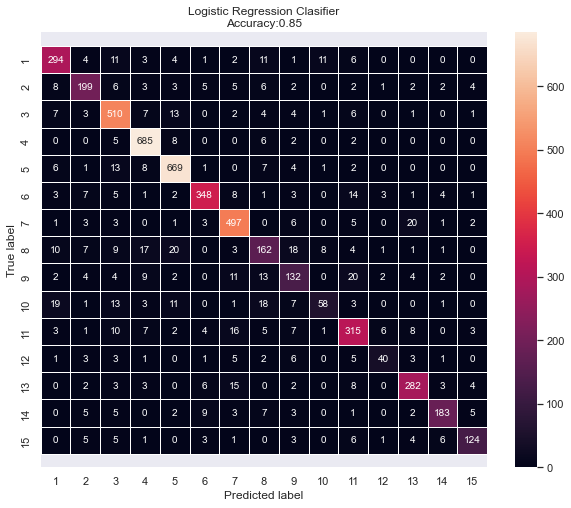

In [9]:
clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train).round(2)*100, "%")
print('Test accuracy:', clf.score(X_test, y_test).round(2)*100, "%")
y_hat = clf.predict(X_test)
show_labels(y_test, y_hat, title = 'Logistic Regression Clasifier', class_range = (1,16))

In [10]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           1       0.83      0.84      0.84       348
           2       0.81      0.80      0.81       248
           3       0.84      0.91      0.88       559
           4       0.92      0.97      0.94       708
           5       0.91      0.94      0.92       712
           6       0.91      0.87      0.89       401
           7       0.87      0.92      0.89       542
           8       0.67      0.62      0.64       261
           9       0.66      0.64      0.65       205
          10       0.72      0.43      0.54       135
          11       0.79      0.81      0.80       388
          12       0.74      0.56      0.64        71
          13       0.86      0.86      0.86       328
          14       0.90      0.81      0.85       225
          15       0.86      0.78      0.82       159

    accuracy                           0.85      5290
   macro avg       0.82      0.78      0.80      5290
weighted avg       0.85   

In [11]:
'''check highest predictors to see if model learnt to make sense out of SDGs'''
df_lambda = get_topwords(clf, vectorizer, n = 10, n_models = 15, show_idxmax = True)
print(f'Shape:{df_lambda.shape}')
display(df_lambda)

C:\Users\pizarr_ser\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sdg_1        poverty
sdg_2           food
sdg_3         health
sdg_4      education
sdg_5          woman
sdg_6          water
sdg_7         energy
sdg_8         labour
sdg_9     innovation
sdg_10    inequality
sdg_11          city
sdg_12         waste
sdg_13       climate
sdg_14       fishery
sdg_15        forest
dtype: object

Shape:(15, 1)


,Keywords
sdg_1,"[(poverty, 10.2), (poor, 6.528), (deprivation,..."
sdg_2,"[(food, 7.92), (agricultural, 5.923), (farmer,..."
sdg_3,"[(health, 9.46), (patient, 5.273), (care, 5.14..."
sdg_4,"[(education, 8.321), (student, 7.676), (school..."
sdg_5,"[(woman, 11.899), (gender, 9.616), (female, 5...."
sdg_6,"[(water, 12.178), (groundwater, 5.123), (river..."
sdg_7,"[(energy, 9.111), (electricity, 6.784), (power..."
sdg_8,"[(labour, 4.326), (employment, 4.063), (job, 3..."
sdg_9,"[(innovation, 4.505), (ict, 4.13), (infrastruc..."
sdg_10,"[(inequality, 6.07), (income, 4.045), (worker,..."
